# Convolutional Neural Networks and Image Classification

The image classification problem is the problem of assigning a label to an image. For example, we might want to assign the label "duck" to pictures of ducks, the label "frog" to pictures of frogs, and so on. 

In this lecture, we'll introduce some of the most important tools for image classification: convolutional neural networks. Major parts of this lecture are based on the "Images" tutorial [here](https://www.tensorflow.org/tutorials/images/cnn). 

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

## Getting Data

For this lecture, we'll use a subset of the [CIFAR-10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). This data set can be conveniently accessed using a method from `tensorflow.keras.datasets`: 

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

There are 50,000 training images and 10,000 test images. Each image has 32x32 pixels, and there are three color "channels" -- red, green, and blue. 

In [3]:
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

There are 10 classes of image, encoded by the `labels` arrays. 

In [4]:
train_labels[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

Each class corresponds to a type of object: 

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Let's take a look. 

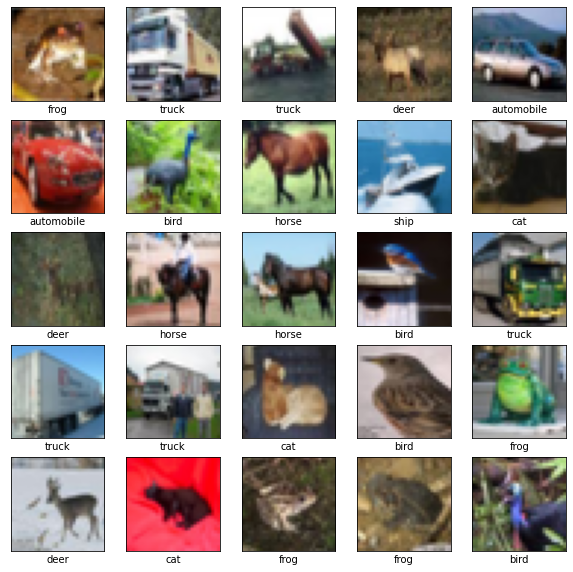

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Convolution

Convolution is a mathematical operation commonly used to extract *features* (meaningful properties) from images. The idea of image convolution is pretty simple. We define a *kernel* matrix containing some numbers, and we "slide it over" the input data. At each location, we multiply the data values by the kernel matrix values, and add them together. Here's an illustrative diagram: 

![](https://d2l.ai/_images/correlation.svg)

*Image from [Dive Into Deep Learning](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)*

The value of 19 in the output is obtained in this example by computing $0 \times 0 + 1 \times 1 + 3 \times 2 + 4 \times 3 = 19$. 

This operation might seem either abstract or trivial, but it can be used to extract useful image features. For example, let's manually define a kernel and use it to perform "edge detection" in a greyscale image. 

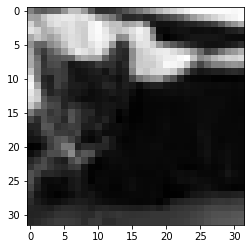

In [7]:
im = train_images[9,:,:,2] # this one's a cat, only taking the "blue" channel for convenience
plt.imshow(im, cmap = "gray")

In [8]:
kernel = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]])

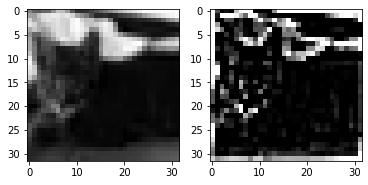

In [9]:
from scipy.signal import convolve2d
convd = convolve2d(im, kernel, mode = "same")
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(im, cmap = "gray")
axarr[1].imshow(convd, cmap = "gray", vmin = 0, vmax = 1)

Observe that the convolved image (right) has darker patches corresponding to the distinct "edges" in the image, where darker colors meet lighter colors. 

## Learning Kernels

There are lots of convolutional kernels we could potentially use. How do we know which ones are meaningful? In practice, we don't. So, we treat them as parameters, and learn them from data as part of the model fitting process. This is exactly what the `Conv2d` layer allows us to do. 

In [10]:
conv = layers.Conv2D(32, (3, 3), 
                     activation='relu', 
                     input_shape=(32, 32, 3),
                     dtype = "float64")

(-0.5, 29.5, 29.5, -0.5)

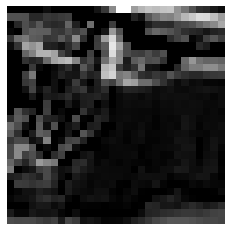

In [11]:
# pick an individual image while preserving dimensions
color_im = train_images[9:10]

# perform convolution and extract as numpy array
convd = conv(color_im).numpy()

# get a single feature (corresponding to one choice of convolution)
feature = convd[0,:,:,1]

plt.imshow(feature, cmap = "gray")
plt.gca().axis("off")

Let's compare a few other possibilities: 

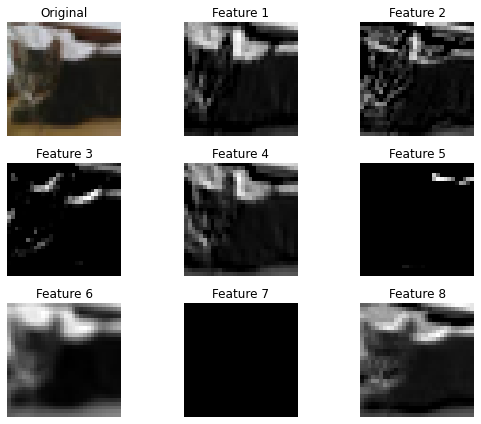

In [12]:
fig, axarr = plt.subplots(3, 3, figsize = (8, 6))

axarr[0, 0].imshow(color_im[0])
axarr[0,0].axis("off")
axarr[0,0].set(title = "Original")

i = 0
for ax in axarr.flatten()[1:]:
    ax.imshow(convd[0,:,:,i], cmap = "gray")
    i += 1
    ax.axis("off")
    ax.set(title = "Feature " + str(i))
    
plt.tight_layout()

These features may or may not be informative -- they are purely random! We can try to learn informative features by embedding these kernels in a model and optimizing. 

## Building a Model

The most common approach is to alternate `Conv2D` layers with `MaxPooling2D` layers. Pooling layers act as "summaries" that reduce the size of the data at each step. After we're done doing "2D stuff" to the data, we then need to `Flatten` the data from 2d to 1d in order to pass it through the final `Dense` layers, which form the prediction. 

In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10) # number of classes
])

What does max pooling do? you can think of it as a kind of "summarization" step in which we intentionally make the current output somewhat "blockier." Technically, it involves sliding a window over the current batch of data and picking only the largest element within that window. Here's an example of how this looks: 

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

*Image credit: Computer Science Wiki*

Ok, now that we know what each of our layers are doing, we can now inspect our model. 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Let's train our model and see how it does! 

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, 
                    train_labels, 
                    epochs=10, 
                    steps_per_epoch = 100,
                    validation_data=(test_images, test_labels))

Epoch 1/10
100/100 [==============================] - 58s 567ms/step - loss: 1.5216 - accuracy: 0.4653 - val_loss: 1.3286 - val_accuracy: 0.5214
Epoch 2/10
100/100 [==============================] - 50s 492ms/step - loss: 1.3056 - accuracy: 0.5339 - val_loss: 1.2702 - val_accuracy: 0.5472
Epoch 3/10
100/100 [==============================] - 58s 584ms/step - loss: 1.2498 - accuracy: 0.5578 - val_loss: 1.2069 - val_accuracy: 0.5700
Epoch 4/10
100/100 [==============================] - 42s 412ms/step - loss: 1.1939 - accuracy: 0.5766 - val_loss: 1.2038 - val_accuracy: 0.5730
Epoch 5/10
100/100 [==============================] - 36s 361ms/step - loss: 1.1508 - accuracy: 0.5933 - val_loss: 1.1518 - val_accuracy: 0.5930
Epoch 6/10
100/100 [==============================] - 37s 371ms/step - loss: 1.1113 - accuracy: 0.6094 - val_loss: 1.1029 - val_accuracy: 0.6140
Epoch 7/10
100/100 [==============================] - 44s 442ms/step - loss: 1.0679 - accuracy: 0.6237 - val_loss: 1.0672 - val_ac

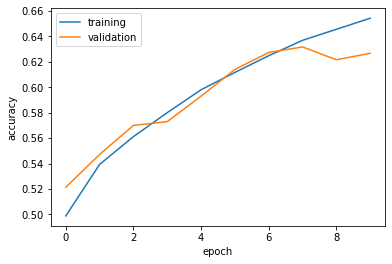

In [19]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

After just a few rounds of training, our model is able to guess the image label more than 50% of the time on the unseen validation data, which is relatively impressive considering that there are 10 possibilities. 

Note: the training process can often be considerably accelerated by training on a GPU. A limited amount of free GPU power is available via Google Colab, and is illustrated [here](https://colab.research.google.com/notebooks/gpu.ipynb). 

## Extracting Predictions

Let's see how our model did on the test data: 

In [20]:
y_pred = model.predict(test_images)
labels_pred = y_pred.argmax(axis = 1)

We'll plot these predicted labels along side the (true labels). 

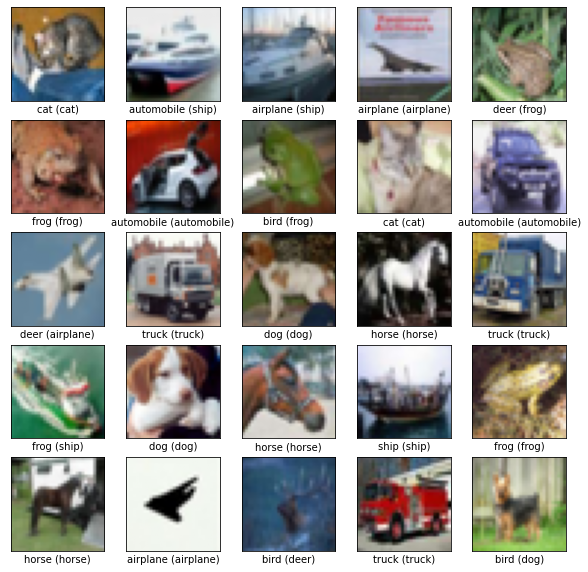

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel(class_names[labels_pred[i]] + f" ({class_names[test_labels[i][0]]})")
plt.show()

Overall, these results look fairly reasonable. There are plenty of mistakes, but it does look like the places where the model made errors are authentically somewhat confusing. A more complex or powerful model would potentially be able to do noticeably better on this data set. 

# Visualizing Learned Features 

It's possible to define a separate model that allows us to study the features learned by the model. These are often called *activations*. We create this model by simply asserting that the model outputs are equal to the outputs of the first convolutional layer. For this we use the `models.Model` class rather than the `models.Sequential` class, which is more convenient but less flexible. 

It's possible to look at the activations at different levels of the model. Generally speaking, it is expected that the activations become more abstract as one goes higher up the model structure. 

In [50]:
activation_model = models.Model(inputs=model.input, 
                                outputs=model.layers[0].output)

Now we can compute the activations

In [51]:
activations = activation_model.predict(train_images[0:10]) 

And visualize them! 

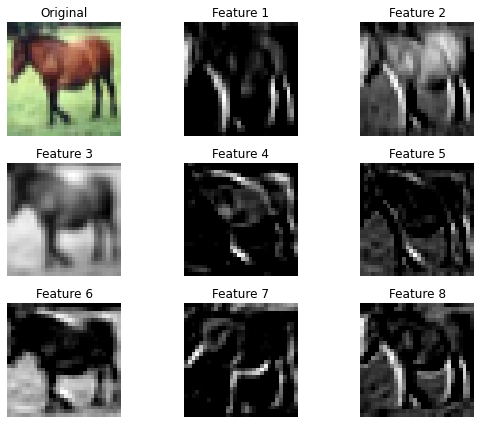

In [59]:
k = 7

color_im = train_images[k:(k+1)]
convd = conv(color_im).numpy()

fig, axarr = plt.subplots(3, 3, figsize = (8, 6))

axarr[0, 0].imshow(color_im[0])
axarr[0,0].axis("off")
axarr[0,0].set(title = "Original")

i = 0
for ax in axarr.flatten()[1:]:
    ax.imshow(activations[k,:,:,i], cmap = "gray")
    i += 1
    ax.axis("off")
    ax.set(title = "Feature " + str(i))
    
plt.tight_layout()

Somewhat romantically, these activations might be interpreted as "how the algorithm looks at" the resulting image. That said, one must be careful of over-interpretation. Still, it looks like some of the features correspond to edge detection (like we saw above), while others correspond to highlighting different patches of colors, enabling, for example, separation of the foreground object from the background. 